# Final Model (Classwise/Y Scaling/Vt Feature/Drain Feature) with XGBoost

In [1]:
import torch
import xgboost
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from joblib import dump, load

In [2]:
vt_model = xgboost.XGBRegressor()
vt_model.load_model('./checkpoints/vt_xgboost.model')

In [3]:
full_df = pd.read_csv('./train_data/merged_train.csv')
full_df.head()

,Vds,Vgs,Ids,W,L,T
0,0.1,-20.0,9.424700e-15,10,5,0
1,0.1,-19.8,9.424700e-15,10,5,0
2,0.1,-19.6,9.424700e-15,10,5,0
3,0.1,-19.4,9.424700e-15,10,5,0
4,0.1,-19.2,9.424700e-15,10,5,0


In [4]:
full_df['Vt'] = full_df.apply(lambda row : vt_model.predict([row[['W','L', 'T','Vds']].to_numpy()])[0], axis=1)
full_df.head()

,Vds,Vgs,Ids,W,L,T,Vt
0,0.1,-20.0,9.424700e-15,10,5,0,0.999947
1,0.1,-19.8,9.424700e-15,10,5,0,0.999947
2,0.1,-19.6,9.424700e-15,10,5,0,0.999947
3,0.1,-19.4,9.424700e-15,10,5,0,0.999947
4,0.1,-19.2,9.424700e-15,10,5,0,0.999947


In [5]:
def calculate_drain_equation(width, length, vgs, vds, vt):
    right_term = (vgs-vt)*vds - 1/2*(vds**2)
    return (width/length)*right_term

In [6]:
full_df['Drain'] = full_df.apply(lambda row : calculate_drain_equation(row['W'], row['L'], row['Vgs'], row['Vds'], row['Vt']), axis=1)
print(full_df)

        Vds   Vgs           Ids     W   L   T        Vt         Drain
0       0.1 -20.0  9.424700e-15    10   5   0  0.999947     -4.209989
1       0.1 -19.8  9.424700e-15    10   5   0  0.999947     -4.169989
2       0.1 -19.6  9.424700e-15    10   5   0  0.999947     -4.129989
3       0.1 -19.4  9.424700e-15    10   5   0  0.999947     -4.089989
4       0.1 -19.2  9.424700e-15    10   5   0  0.999947     -4.049989
...     ...   ...           ...   ...  ..  ..       ...           ...
85621  30.0  19.2  1.238200e-02  1000  12  80  0.599464   9001.341194
85622  30.0  19.4  1.263100e-02  1000  12  80  0.599464   9501.341194
85623  30.0  19.6  1.288200e-02  1000  12  80  0.599464  10001.341194
85624  30.0  19.8  1.313300e-02  1000  12  80  0.599464  10501.341194
85625  30.0  20.0  1.338700e-02  1000  12  80  0.599464  11001.341194

[85626 rows x 8 columns]


In [7]:
class_0_df = full_df.query('Vgs<0')
class_1_df = full_df.query('Vgs>=0')

In [8]:
class_0_y = class_0_df[['Ids']].to_numpy()
class_0_y = np.log(class_0_y)

class_0_X = class_0_df[['W','L','T','Vgs','Vds', 'Vt', 'Drain']].to_numpy()
scaler_0_X = StandardScaler().fit(class_0_X)
class_0_X = scaler_0_X.transform(class_0_X)
dump(scaler_0_X, './scalers/class_scale_vt_drain_xbgoost_class_0_std_scaler.bin', compress=True)

['./scalers/class_scale_vt_drain_xbgoost_class_0_std_scaler.bin']

In [9]:
class_0_xgb_model = xgboost.XGBRegressor(objective='reg:squarederror')
class_0_xgb_model.fit(class_0_X, class_0_y)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

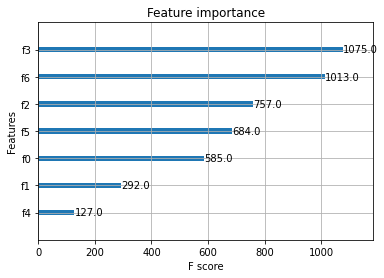

In [10]:
xgboost.plot_importance(class_0_xgb_model)

In [11]:
r_sq = class_0_xgb_model.score(class_0_X, class_0_y)
print(r_sq)

0.9999435661197038


In [12]:
class_0_xgb_model.save_model('./checkpoints/class_scale_vt_drain_xgboost_class_0.model')

In [13]:
class_1_y = class_1_df[['Ids']].to_numpy()
class_1_y = np.log(class_1_y)

class_1_X = class_1_df[['W','L','T','Vgs','Vds', 'Vt', 'Drain']].to_numpy()
scaler_1_X = StandardScaler().fit(class_1_X)
class_1_X = scaler_1_X.transform(class_1_X)
dump(scaler_1_X, './scalers/class_scale_vt_drain_xbgoost_class_1_std_scaler.bin', compress=True)

['./scalers/class_scale_vt_drain_xbgoost_class_1_std_scaler.bin']

In [14]:
class_1_xgb_model = xgboost.XGBRegressor(objective='reg:squarederror')

In [15]:
class_1_xgb_model.fit(class_1_X, class_1_y)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=100, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, ...)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

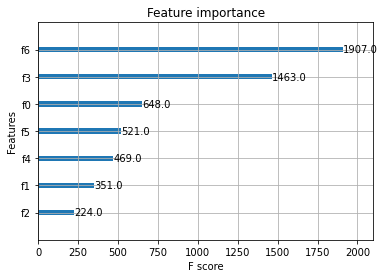

In [16]:
xgboost.plot_importance(class_1_xgb_model)

In [17]:
r_sq = class_1_xgb_model.score(class_1_X, class_1_y)
print(r_sq)

0.9996947013080268


In [18]:
class_1_xgb_model.save_model('./checkpoints/class_scale_vt_drain_xgboost_class_1.model')